# Homework 3
## M. Fernandez, T. Kreienkamp & J.Verdu

###Data
The data we are going to analyse comes from EUR-Lex (http://eur-lex.europa.eu/homepage.html), a site where EU law and other public EU documents can be found. For the extration of the data we decided to take al the legislation documents from 2005 to 2015. Moreover the word "palestine" should be found in the search. 

###Objective
This code is going to use LSA to look for similarities between documents. Finally we are going to compare the results of LSA with some of the results from last weeks HW with dictionary methods.

###Coding
First thing we need to compute is the TF-IDF score of all the unique terms in all of our documents, that will be the term-document matrix. This part is implemented in HW3_ex01.py in the HW3 folder. We'll directly import the term-document matrix with the scores of all words in all of our documents.

In [2]:
from __future__ import division
import pandas as pd   
from sklearn.metrics.pairwise import cosine_similarity
# Import data
X = pd.read_table("X_Matrix.CSV",encoding="utf-8") 


Once we have our term-document matrix we need to compute the SVD transformation of the X matrix:

In [3]:

import numpy as np

U, S, V = np.linalg.svd(X, full_matrices=False)

# look for the percentage of explained variance.

singlevalues=[]
for ss in S:
    singlevalues.append(np.power(ss,2))

NormSV =[] 
for ss in singlevalues:
    NormSV.append(ss/sum(singlevalues))
    
cumSV=[]
cumSV.append(NormSV[0])
for i in range(2,170):
    cumSV.append(sum(NormSV[0:i]))    



To know how many single values we need to keep we are going to plot the percentage of variance explained:

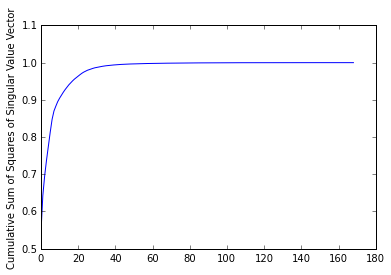

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(cumSV)
plt.ylabel('Cumulative Sum of Squares of Singular Value Vector')
plt.show()


We can see that with 20 single values we would have almost all of the variance explained. With about 10 single values we would have already 90% of the variance. For the rest of the exercice we are going only to keep 10 single values.

In [5]:

#Element 17th is the first one to contain 99% of the variance:
k=10
U_k = U[:, :k]
sigma = np.diag(S[:k])
V_k = V[:k, :]
X_k = np.dot(U_k, np.dot(sigma,V_k))

Once we have our new term-document matrix we need to compute the cosine similarity of both of the term-document matrices:

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
cs=cosine_similarity(X.T)
cs_k=cosine_similarity(X_k.T)

We know a cosine similarity matrix is simply the correlation two documents have in respect of the word composition. To see the difference between both of the cosine similarity matrix we simply have to do a basic heatmap. Since it's the simpler way of graphically representing correlations.
We should espect that the cosine similarity matrix done with less single values have higher correlations than the original data. The folowing graphs should help use understand the theory:

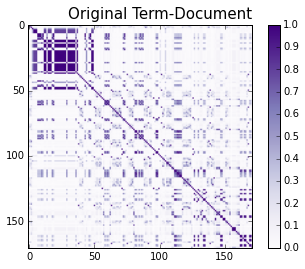

In [28]:
import numpy as np
import pylab as plt


# Scale the values from .9 to 1.0 using vmin,vmax
plt.imshow(cs, vmin=0,vmax=1.0,cmap='Purples')
plt.text(100,-5,'Original Term-Document',
         fontsize=15,
         horizontalalignment='center')
plt.colorbar()
plt.show()

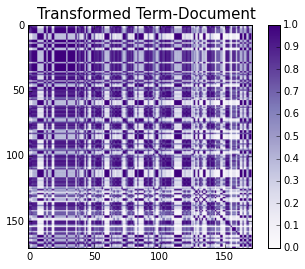

In [27]:
# Scale the values from .9 to 1.0 using vmin,vmax
plt.imshow(cs_k, vmax=1.0,vmin=0,cmap='Purples')
plt.text(90,-5,'Transformed Term-Document',
         fontsize=15,
         horizontalalignment='center')
plt.colorbar()
plt.show()

We can see that indeed the cosine similarity matrix of the original term-document matrix has less correlations between documents. That means that by applying SVD we reduce roise, and can see better interpret correlations between the documents.

###Compare with dictionary method

From the previous homework we had to use different dictionaries to see what our documents talked about. All the documents had different TF-IDF score depending on the dictionary. From does scores we looked for the prioritary topic in the document, so we ended having the main topic of all the documents. Common sense would say that documents labeled with the same topic should have a high correlation. But let's check the numbers:

In [29]:

result = pd.read_table("data_puntuation.csv")

topics=result[['Eco_TD','Legal_TD','Military_TD','Religion_TD']]
topics=topics.reset_index(drop=True)
rowmax = topics.max(axis=1)
maxTopic=np.where(topics.values == rowmax[:,None]) # which is maximum of the 4 categories
maxTopicInd=maxTopic[1]
IndTopic=maxTopic[0]

#None of the documents prefare Religion theme, so we'll study 
## the other topics.

#Sometimes there are ties, so we will keep only one of the 3 topics,
#well keep only one
TopicIndex=[]
j=0
for i in range(0,186):
    if IndTopic[i]==j:
        TopicIndex.append(maxTopicInd[i])
        j=j+1
        
        
    

def similarity(topic1, topic2, topicInd, cs_mat):
    similarity = 0.0
    counter = 0.0
    for i in range(0, len(topicInd)):
        for j in range(0, len(topicInd)):
            if topicInd[i] == topic1 and topicInd[j] == topic2 and i != j:
                similarity += cs_mat[i,j]
                counter +=1.0
    similarity = similarity/counter
    return similarity

noTopics = len(np.unique(TopicIndex))
similarity_matrix_k = np.zeros((noTopics, noTopics))

for i in range(0, noTopics):
    for j in range(0, noTopics):
        similarity_matrix_k[i,j] = similarity(i, j, TopicIndex, cs_k)
    


In [30]:
similarity_matrix_k

array([[ 0.61126513,  0.59773085,  0.43071344],
       [ 0.59773085,  0.60870146,  0.53801121],
       [ 0.43071344,  0.53801121,  0.78702194]])

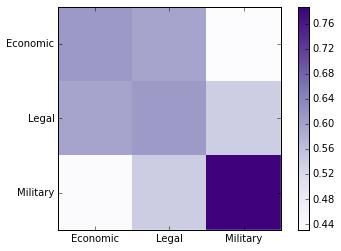

In [31]:

plt.imshow(similarity_matrix_k,interpolation='none',cmap='Purples')
plt.xticks(range(3), ['Economic', 'Legal', 'Military'])
plt.yticks(range(3), ['Economic', 'Legal', 'Military'])


plt.colorbar()
plt.show()

From this heatmap we can see that there is high correlation between legal dictionary and economic dictionaries. We have to take into account that most documents belong to Economic Topic, and on the other hand, only three documents in belong to militar. So having a high correlation between militaries documents makes sense, since it's more restrictive the vocabulary and fewer documents are in this category.

Also we can see that the difference between the dictionary method or LSA. In LSA economic and legal documents are very correlated, so maybe, we should consider other ways of identifying the document's topic.